In [242]:
import pandas as pd
import numpy as np
import networkx as nx

from sklearn.utils import extmath
import scipy
from scipy.spatial.distance import pdist, squareform
from scipy import sparse, stats, spatial
from scipy.sparse import csr_matrix
from pandas.api.types import CategoricalDtype
from scipy.spatial.distance import cdist, squareform
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import NMF

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
data_folder = './data/Main/'

# 1. Preparing necessary datasets

## 1.1. Loading tracks metadata

In [4]:
# Loading 'tracks' dataset
tracks = pd.read_csv(data_folder+'tracks.csv', 
                        index_col=0, encoding='utf-8', low_memory=False)

### Mapping trackID to numeric ID

# Getting unique trackID
unique_trackID = tracks.trackID.unique()

# Creating a dictionary to assign numeric ID to each trackID
dict_trackID = dict(zip(unique_trackID, range(unique_trackID.size)))

# Mapping trackID to numeric ID using 'dict_trackID' dictionary
tracks['trackID'] = tracks.trackID.map(dict_trackID)

print(tracks.shape)
tracks.head(3)

(64500, 14)


,trackID,trackTitle,artistName,trackPopularity,releaseDate,artistFollowers,topGenre1,topGenre2,artistID,albumID,songID,audio_Duration_ms,set_subset,set_split
0,0,The Room Of Stairs,Harold Budd,11.0,2000,30414.0,Electronic/Dance,Classical,3uOCouLFR4bVx0XeiQJSbl,3jq7b66l8MswqDmi0mxzjq,SOAAADD12AB018A9DD,321133,medium,train
1,1,(I'm Gonna Start) Living Again If It Kills Me,Dave Edmunds,5.0,1981,28604.0,Rock,Blues,65Gh3BfK84aTIugiRCgLBA,0upTl2RUS4gmStWBlXjt9l,SOAAADE12A6D4F80CC,199088,medium,train
2,2,KRYSAR (LIVE),LANDA DANIEL,15.0,2003,NaN,NaN,NaN,6rSpV5hdCNJ4v1i602nj22,7uvLu2RAki7aKiASSxJPzi,SOAAADF12A8C13DF62,200880,medium,train


In [5]:
# Loading filtered tracks dataset
tracks_s = pd.read_csv(data_folder+'tracks_filtered.csv', encoding='utf-8', index_col=0, low_memory=False)

## 1.2. User profile data

In [6]:
# Loading playlists dataset
user_profile = pd.read_csv(data_folder+'userProfile.csv', 
                        index_col=0, encoding='utf-8', low_memory=False)

# Keeping only tracks that exists in tracks dataframe
user_profile = user_profile[user_profile.trackID.isin(list(dict_trackID.keys()))]

print(user_profile.shape)
user_profile.head(3)

/root/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


(4911782, 4)


,userID,songID,counts,trackID
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBSUJE12A6D4F8CF5,2,2ECKXkpPAxky87ohawpaeD
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBVFZR12A6D4F8AE3,1,5WjXULJvSlMxuies9diz1Q
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXALG12A8C13C108,1,1bqi9YEdZweX9H6JuSQ6Qw


In [7]:
### Mapping userID to numeric ID

# getting unique userID
unique_userID = user_profile.userID.unique()

# Creating a dictionary to assign numeric ID to current user ID
dict_userID = dict(zip(unique_userID, range(unique_userID.size)))

# Mapping userID using prepared dictionary
user_profile.userID = user_profile.userID.map(dict_userID)

# Mapping trackID to numeric ID using 'dict_trackID' dictionary
user_profile.trackID = user_profile.trackID.map(dict_trackID)

user_profile = user_profile[['userID', 'trackID', 'counts']]

user_profile.head(4)

,userID,trackID,counts
0,0,10544,2
1,0,10979,1
2,0,11263,1
3,0,23923,1


In [8]:
print('Number of unique songs ID: {}'.format(user_profile.trackID.unique().shape[0]))

Number of unique songs ID: 64500


In [9]:
# Loading the saved mapped 'user_profile'
user_profile_s = pd.read_csv(data_folder+'user_profile_mapped_s.csv', encoding='utf-8', index_col=0)

/root/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


## 1.3. Audio Features

In [11]:
# Loading 'audio_features' dataset
audio_features = pd.read_csv(data_folder+'audio_features.csv', 
                        index_col=0, encoding='utf-8', low_memory=False)


# Filter audio features to only the songs that exists in trackID
audio_features = audio_features[audio_features.trackID.isin(list(dict_trackID.keys()))]

# Mapping trackID to numeric ID using 'dict_trackID' dictionary
audio_features['trackID'] = audio_features.trackID.map(dict_trackID).astype(int)

print(audio_features.shape)
audio_features.head(3)

(64500, 12)


,trackID,audio_Danceability,audio_Energy,audio_Key,audio_Loudness,audio_Mode,audio_Speechiness,audio_Acousticness,audio_Instrumentalness,audio_Liveness,audio_Valence,audio_Tempo
0,0,0.225,0.135,3,-26.040,0,0.0382,0.888,0.6570,0.051,0.0377,81.807
1,1,0.509,0.347,4,-16.711,1,0.0273,0.273,0.0328,0.298,0.5220,102.604
2,2,0.339,0.787,9,-6.285,0,0.0539,0.313,0.0196,0.710,0.4200,157.042


## 1.4. Librosa Features

In [12]:
# Loading 'librosa_features' dataset
features = pd.read_csv(data_folder+'librosa_features.csv', 
                        index_col=0, header=[0,1,2], encoding='utf-8', low_memory=False)

# Converting multi-index columns to flat index
features.columns = [ '_'.join(x) for x in features.columns ]

# Filter Librosa feature to the songs that exists in tracks dataframe
features = features[features.index.isin(list(dict_trackID.keys()))]

# Mapping trackID to numeric ID using 'dict_trackID' dictionary
features.index = features.index.map(dict_trackID).astype(int)

print(features.shape)
features.head(3)

(64500, 518)


,chroma_cens_kurtosis_01,chroma_cens_kurtosis_02,chroma_cens_kurtosis_03,chroma_cens_kurtosis_04,chroma_cens_kurtosis_05,chroma_cens_kurtosis_06,chroma_cens_kurtosis_07,chroma_cens_kurtosis_08,chroma_cens_kurtosis_09,chroma_cens_kurtosis_10,...,tonnetz_std_04,tonnetz_std_05,tonnetz_std_06,zcr_kurtosis_01,zcr_max_01,zcr_mean_01,zcr_median_01,zcr_min_01,zcr_skew_01,zcr_std_01
0,0.720673,4.240027,-0.618995,0.426698,-0.226265,-0.209698,-0.317341,-1.345874,-0.586116,-0.931247,...,0.084099,0.017905,0.017880,3.022421,0.400879,0.093924,0.078125,0.030273,1.610670,0.054095
1,-0.370662,-0.287299,1.182948,-0.952800,-0.790715,-0.504890,-0.491160,0.696574,0.054538,0.780068,...,0.127805,0.020186,0.023055,13.629067,0.286621,0.046816,0.042969,0.008301,2.550661,0.024498
2,-0.769198,-0.571088,-0.860308,0.437645,-1.027899,1.226321,-0.928717,1.680385,-1.276514,-0.994085,...,0.084305,0.018808,0.020520,10.252457,0.222168,0.053373,0.049316,0.013184,2.536385,0.023678


In [13]:
# Loading the filtered version of 
features_s = pd.read_csv(data_folder+'features_filtered.csv', encoding='utf-8', index_col=0, low_memory=False)

# 2. Loading songs similarity graph 

## 2.1. Similarity graph made using Librosa features

In [15]:
# Loading the prepared graph
G_tracks = nx.read_gpickle("similarity_based_on_librosa.gpickle")

In [16]:
# Creating a list of nodes names
nodes_name = tracks_s.trackID.values 

nodes_name = nodes_name[np.isin(nodes_name, list(G_tracks.nodes()))]

In [35]:
# Loading weights matrix prepared using Librosa features
weights = sparse.load_npz("weights_based_on_Librosa.npz")

In [17]:
# Checking if the graph is connected
print(nx.is_strongly_connected(G_tracks))
# Getting the number of Connected components
print('There are {} connected components!'.format(nx.number_strongly_connected_components(G_tracks)))

False
There are 85 connected components!


In [18]:
# Getting connected components
components = []
for component in nx.strongly_connected_components(G_tracks):
    components.append(component)

# Sorting the connected components based on their number of nodes
components.sort(key=lambda x: len(x))

# Creating a subgraph of G_tracks whihc contains selected songs 
### (here 500 songs selected in "creating utility matrix" step)
G_tracks = G_tracks.subgraph(sorted(list(components[-1])))

# 2.2.Loading songs similarity network (made from user profile)

In [19]:
# Loading the prepared graph
G_tracks_h = nx.read_gpickle("similarity_based_on_userProfile.gpickle")

In [36]:
# Loading weights matrix prepared using user Profile
weights_h = sparse.load_npz("weights_based_on_userProfile.npz")

# 3. Creatin utility matrix

In [20]:
# Creating a sparse matrix from 'user_profile' dataframe
userID_cat = CategoricalDtype(user_profile_s.userID.unique(), ordered=True)
trackID_cat = CategoricalDtype(nodes_name, ordered=True)

row = user_profile_s.userID.astype(userID_cat).cat.codes
col = user_profile_s.trackID.astype(trackID_cat).cat.codes
sparse_utility = csr_matrix((user_profile_s['counts'], (row, col)), \
                             shape=(userID_cat.categories.size, trackID_cat.categories.size))

# Defining the sparse DataFrame
utility_df = pd.SparseDataFrame(sparse_utility, \
                         index=userID_cat.categories, \
                         columns=trackID_cat.categories, \
                         default_fill_value=0)

utility_df.head()

,5,10,11,21,22,27,29,41,42,44,...,64443,64447,64455,64459,64460,64461,64468,64473,64488,64490
4,0,0,0,0,0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 4.Exploring most popular songs

In [95]:
tracks_s.sort_values(by=['artistFollowers'], ascending=False).drop_duplicates(subset=['artistName']).head()

,trackID,trackTitle,artistName,trackPopularity,releaseDate,artistFollowers,topGenre1,topGenre2,artistID,albumID,songID,audio_Duration_ms,set_subset,set_split
56819,56819,Lately,David Guetta,13.0,2002,17164967.0,Pop,Electronic/Dance,1Cs0zKBU1kc0i8ypK3B9ai,78M16AQffV0YUfvseg60MT,SOTBSXB12A6D4F7E06,100840,small,train
61373,61373,Careful Where You Stand,Coldplay,38.0,2000,16941698.0,Punk,Pop,4gzpq5DPGxSnKTe4SA8HAU,2rd83EFsdLMTyrgVizvpxX,SOWOZBR12A8C13F4F6,285027,small,train
62711,62711,Proud To Be An American,Beyoncé,21.0,2008,16925982.0,Pop,Pop,6vWDO969PvNqNYHIOW5v0m,6LvTkhsKHuUDVEAAAzonjc,SOXXORZ12AB0184DC5,163376,small,train
59937,59937,Te Necesito,Shakira,48.0,1995,14852073.0,Pop,Pop,0EmeFodog0BfCgMzAIvKQp,3HLngzP9wVd8p3SMDQgyd9,SOVJQJJ12A8C1448E7,240227,small,test
43896,43896,What I've Done - Distorted Remix,Linkin Park,21.0,2007,11124030.0,Metal,Metal,6XyY86QOPPrYVGvF9ch6wz,2OFwcSIo57lA6rm4xhpGzE,SOMEAKJ12A6D4FBC99,227573,small,test


In [238]:
song_pop = np.where(utility_df.columns==59937)[0][0]

In [239]:
idx = np.argsort(H_songs[:, song_pop])
concept_pop = idx[-1]

In [240]:
concept_pop

63

# 5. Computing Personalized Vector

## 5.1. Decomposing utility matrix using Non-negative Matrix Factorization

In [229]:
n_components = 100
# We use 'kullback-leibler' betaloss as it has been suggested in the paper
model_utility = NMF(n_components=n_components, solver='mu', beta_loss='kullback-leibler', 
                    tol=0.0001, max_iter=200).fit(sparse_utility)

In [243]:
user_id_s = 12000
n_components =100
# Creating an imaginary user which like popular songs
W_users = np.zeros((n_components,)) #model_utility.transform(sparse_utility[trackID_cat.categories[user_id_s],:].toarray()).reshape(-1)
W_users[concept_pop] = 10
H_songs = model_utility.components_

In [244]:
W_users

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 10.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [24]:
H_songs.shape

(30, 12900)

## 5.2. Getting the most liked concept by the user

In [245]:
### Get songs probability for some user_num

# Getting the sorted index of the user interests to different concepts
conceptSort_idx = np.argsort(W_users)
best_concept = conceptSort_idx[-1]

# Getting the concept that user likes the most
songs_concept = H_songs[best_concept,:]
#songs_concepts = songs_concepts/songs_concepts.sum()

In [247]:
# Handling outliers
percentile_cut = np.percentile(songs_concept, 99.97)
songs_concept[songs_concept>=percentile_cut] = percentile_cut

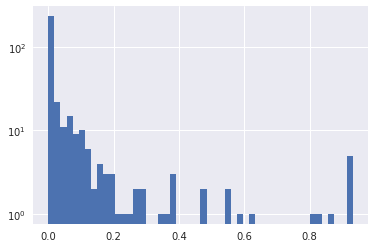

In [248]:
#Displaying the histogram of the distances before sparsifying
plt.hist(songs_concept[songs_concept!=0], bins=50);
plt.yscale('log')

## 5.3. Computing user personalized vector using Personalized PageRank

In [249]:
alpha = 0.85

page_rank = nx.pagerank(G_tracks_h, alpha=alpha, personalization=dict(zip(nodes_name, songs_concept)), max_iter=100, 
                        tol=1e-06, nstart=None, weight='weight', dangling=None)

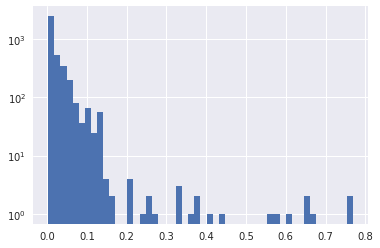

In [250]:
perc_page = np.array(list(page_rank.values()))*100

# Get the sorted index of PageRank
pr_idx = np.argsort(perc_page)

# Keeping only 20 percent of songs with highest PageRank
songs_num = perc_page.shape[0]
perc_drop = 0.7


_ = plt.hist(perc_page[pr_idx[int(songs_num*perc_drop):]], bins=50)
_ = plt.yscale('log')

## 5.4. Keeping most relevant songs based on personalization vector

In [251]:
# Keeping only 20 percent of songs with highest PageRank
songs_num = perc_page.shape[0]
perc_drop = 0.7

# Calculating indices of songs to drop
idx_drop = pr_idx[:int(songs_num*perc_drop)]
idx_drop.sort()

idx_drop.shape

(8969,)

In [252]:
# Getting the last version of nodes name
nodes_name = np.array(list(page_rank.keys()))
nodes_name.sort()

In [253]:
# Defining weights_sub dataframe
weights_sub = pd.DataFrame(weights.toarray(), index=tracks_s.trackID, columns=tracks_s.trackID)

In [254]:
# Keeping only connected conponents
weights_sub = weights_sub.loc[nodes_name, nodes_name]

weights_sub.head()

trackID,5,10,11,21,22,29,41,42,44,46,...,64443,64447,64455,64459,64460,64461,64468,64473,64488,64490
trackID,,,,,,,,,,,,,,,,,,,,,
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [255]:
# Dropping columns
weights_sub = weights_sub.drop(weights_sub.columns[idx_drop.tolist()], axis=1)

# Dropping rows
weights_sub = weights_sub.drop(weights_sub.index[idx_drop.tolist()], axis=0)

weights_sub.head()

trackID,87,94,162,180,184,232,238,265,271,275,...,64292,64334,64355,64403,64410,64411,64421,64426,64443,64455
trackID,,,,,,,,,,,,,,,,,,,,,
87,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
94,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
162,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
180,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
184,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [256]:
# First step of sparsifying: Based on weights
sp_thr = 0.15
weights_sub[weights_sub<=sp_thr] = 0

In [257]:
# We sparsify based on outdegree of each node: a[0,:] show out-going edges
### This is because in the algorithms that we will use, 
### ...in-degree contains information that we don't want to lose
Edges = 30

sort_idx = np.argsort(weights_sub.values, axis=1)
#Leaving all but the 50 strongest edges
for i,index in enumerate(sort_idx):
    weights_sub.iloc[i, index[:-Edges]] = 0


In [258]:
# Getting sparse matrix
weights_sp = sparse.csr_matrix(weights_sub.values)

# Building a graph from Sparse CSR matrix
G_tracks_s = nx.from_scipy_sparse_matrix(weights_sp, create_using=nx.DiGraph(), edge_attribute='weight')

# Relabeling the nodes (name of nodes: TrackID)
G_tracks_s = nx.relabel_nodes(G_tracks_s, dict(zip(range(len(G_tracks_s.nodes())),weights_sub.index.values)))

In [259]:
# Checking if the graph is connected
print(nx.is_strongly_connected(G_tracks_s))
# Getting the number of Connected components
print('There are {} connected components!'.format(nx.number_strongly_connected_components(G_tracks_s)))

False
There are 287 connected components!


In [260]:
components = []
for component in nx.strongly_connected_components(G_tracks_s):
    components.append(sorted(list(component)))

In [261]:
components.sort(key=lambda x: len(x))

In [262]:
len(components[-1])

3543

In [263]:
# Creating a subgraph of G_tracks whihc contains selected songs 
### (here 500 songs selected in "creating utility matrix" step)
G_subgraph = G_tracks_s.subgraph(components[-1])

# 6. Selecting Seed and End Songs

## 6.1. Defining userTaste dataframe

In [264]:
pr_values = list(page_rank.values())
pr_nodes = list(page_rank.keys())

In [265]:
# Defining the user_taste 
user_taste = pd.DataFrame(dict(trackID=pr_nodes, pageRank=pr_values))

# Filtering songs to the ones that were left
user_taste = user_taste[user_taste.trackID.isin(components[-1])]

# Reseting index
user_taste = user_taste.reset_index(drop=True)
print(user_taste.shape)
user_taste.head()

(3543, 2)


,trackID,pageRank
0,87,0.000256
1,94,0.000124
2,162,0.000072
3,180,0.000074
4,184,0.000028


## 6.2. Normalizing userTaste PageRank values

In [266]:
# song_concepts vector contains information about how likely the user...
# will like each song, we need to normalize it from 0 to 1.
Min=np.min(user_taste.pageRank.values)
Max=np.max(user_taste.pageRank.values)
#Normalized version of sonf_concepts, we call it User_pref_norm because it represents the preference of the user.
user_taste.pageRank=(user_taste.pageRank-Min)/(Max-Min)

user_taste.head()

,trackID,pageRank
0,87,0.029830
1,94,0.012604
2,162,0.005729
3,180,0.006013
4,184,0.000031


## 6.3. Creating mood matrix

In [267]:
#Generating the matrix with the 10 audio features
mood_matrix = audio_features[audio_features.trackID.isin(user_taste.trackID)]

# Resetting index
mood_matrix = mood_matrix.set_index('trackID')

print(mood_matrix.shape)
mood_matrix.head()


(3543, 11)


,audio_Danceability,audio_Energy,audio_Key,audio_Loudness,audio_Mode,audio_Speechiness,audio_Acousticness,audio_Instrumentalness,audio_Liveness,audio_Valence,audio_Tempo
trackID,,,,,,,,,,,
87,0.273,0.783,5,-6.875,1,0.0425,0.000019,0.903,0.3070,0.8100,104.396
94,0.189,0.908,3,-4.868,1,0.0700,0.000001,0.917,0.3030,0.0383,108.545
162,0.533,0.987,1,-5.037,1,0.0466,0.000292,0.116,0.3440,0.7120,142.991
180,0.338,0.510,11,-8.759,1,0.0314,0.915000,0.246,0.5160,0.1740,88.739
184,0.734,0.552,0,-10.569,1,0.0539,0.092600,0.910,0.0665,0.4140,153.754


## 6.4. Selecting seed and end song based on user input

In [268]:
Lambda=0.4 #factor defining how much the song should be in the user's preferences

def song_selection(Danceability,Energy,Valence):
        #Then  we create the disance from the 3 features and keep the last column 
        distances = cdist([[Danceability,Energy,Valence]], mood_matrix[['audio_Danceability', 'audio_Energy','audio_Valence']], 
                          metric='sqeuclidean')

        #We convert that distance in weights, using the weighting method seen in class
        kernel_width = distances.mean()
        mood_weights = np.exp(-distances**2 / kernel_width**2)

        #mood_weights=distweights(np.shape(distweights)[0],:)

        # generation of final scores taking into account moods and user:
        selectedsong = mood_weights + Lambda * user_taste.pageRank.values

        #We get as output the index of the song that is the most compatible.
        selectedsong2=user_taste.loc[np.argmax(selectedsong),'trackID']    

        return selectedsong2

In [269]:
# Selecting end song
end_song=song_selection(0.9,0.9,0.9)
end_song

31491

In [270]:
# Selecting seed song
seed_song=song_selection(0.1,0.1,0.1)
seed_song

51076

# 7. Generating Final Playlist

## 7.1. Getting all simple paths

In [271]:
nodes_sample = components[-1]

In [272]:
nx.shortest_path_length(G_subgraph, source=seed_song, target=end_song)

6

In [276]:
simple_paths = []
for path in nx.all_simple_paths(G_subgraph, source=seed_song, 
                                target=end_song, cutoff=8):
    simple_paths.append(path)

In [277]:
len(simple_paths)

599

## 7.2. Keeping the 50% of paths based on connection scores

In [302]:
score = 0
scores = []
#dic_pathWeight = dict(zip(range(len(simple_paths)), [0]*len(simple_paths)))

for item in range(len(simple_paths)): #dic_pathWeight.keys():
    for i, j in zip(simple_paths[item], simple_paths[item][1:]):
        score += G_subgraph.get_edge_data(i, j)['weight']
    scores.append(score)
    score=0

scores = np.array(scores)

In [307]:
np.percentile(scores, 50)

4.9123987142233645

In [313]:
scores[np.where(scores>np.percentile(scores, 50))].shape

(8929,)

In [306]:
scores_idx = np.argsort(scores)

scores[scores_idx[1000]]

4.350224898097361

In [200]:
simple_paths[0]

[61832, 6679, 1299, 828, 34363, 13603, 8474, 49990, 56619]

## 7.3. Selecting the optimal playlist based on smoothness and user's insterest

In [278]:
#Initializing the smoothness and user playlist score vector
users_playlist_score = np.zeros(np.shape(simple_paths)[0])
smoothness=np.zeros(np.shape(simple_paths)[0])

In [279]:
#adjacency2Incidence function that computes incidence matrix from adjacency
def adjacency2Incidence(A):
    '''
    Gets adjacency matrix as inputs and
    Returns the Incidence matrix from the adjacency matrix
    '''
    # The rows are summed up to obtain the degree for each of the nodes
    degree = np.array([np.sum(e) for e in A.T])
    #Calculating diagonal matrix
    D = np.diag(degree)
    
    # Getting the indices of upper triangle of the matrix
    A_triu = np.triu(A)
    # Getting pairs of indices for each edges
    x, y = np.where(A_triu!=0)
    
    num_e = x.shape[0] #number of edges
    num_n = A.shape[0] #number of nodes
    
    # Getting the square root of Weights
    W_sq = np.sqrt(A)
    #Initilizing the incidence matrix
    S = np.zeros((num_n, num_e))
    
    # Filling the incidence matrix
    for i, j, k in zip(x,y, range(num_e)):
        S[i,k] = W_sq[i,j]
        S[j,k] = -W_sq[i,j]
    
    # Normalizing the incidence matrix (to get the consistent answer for laplacian)
    #S_norm = np.linalg.inv(np.sqrt(D))@S
    
    return S #, S_norm

In [280]:
selected_audio = ['audio_Danceability', 'audio_Energy', 'audio_Speechiness', 'audio_Acousticness', 
                  'audio_Instrumentalness', 'audio_Valence', 'audio_Tempo']

In [281]:
###Evaluation of each path in terms of smoothness and user preference (filling of the score vectors)

for i in range(0, len(simple_paths)):
    #Smoothness
    # Keeping only connected conponents
    A1 = weights_sub.loc[simple_paths[i], simple_paths[i]] #weights_sub.loc[user_taste.trackID, user_taste.trackID]
    gradient = adjacency2Incidence(A1.values).T
    gradient_sp = sparse.csr_matrix(gradient)
    mood_matrix_sp = sparse.csr_matrix(mood_matrix.loc[simple_paths[i], selected_audio])
    
    product = gradient_sp@mood_matrix_sp
    smoothness[i] = scipy.sparse.linalg.norm(product , ord='fro')
    
    #User Preferance
    SCORE=np.sum(user_taste[user_taste.trackID.isin(simple_paths[i])].loc[:,'pageRank'])
    
    users_playlist_score[i]=SCORE


In [282]:
# Keeping only connected conponents
#weights_sub = weights_sub.loc[nodes_name, nodes_name]

In [283]:
#Normalising the score vectors for them to be comparable
smoothness_norm=(smoothness-np.min( smoothness))/(np.max( smoothness)-np.min( smoothness))
users_playlist_score_norm=(users_playlist_score-np.min( users_playlist_score))/(np.max( users_playlist_score)-np.min(users_playlist_score))



In [284]:
#Lambda parameter to quantify how important the user's preference  *defined above)  
#Lambda=0.3

cost_list = smoothness_norm - Lambda*users_playlist_score_norm

optimal_path=simple_paths[np.argmin(cost_list)]

print(optimal_path)

[51076, 35269, 24281, 30837, 12675, 27071, 35730, 184, 31491]


In [285]:
### Getting the final table of all generated songs
optimal_path_df = tracks[tracks.trackID.isin(optimal_path)].copy()

# creating a dictionary for adding song position column
dict_path_position = dict(zip(optimal_path, range(len(optimal_path))))
# Adding position id to the dataframe
optimal_path_df['positionID'] = optimal_path_df.trackID.map(dict_path_position)
optimal_path_df = optimal_path_df.sort_values(by=['positionID'])

optimal_path_df = optimal_path_df[['positionID', 'trackTitle', 'artistName', 'releaseDate', 'topGenre1', 'audio_Duration_ms']]

optimal_path_df

,positionID,trackTitle,artistName,releaseDate,topGenre1,audio_Duration_ms
51076,0,The Spirit Of Christmas Past,Enya,2008,Folk&Accoustic,258067
35269,1,Losing Momentum (For Jim Jarmusch),Kurt Vile,2010,Pop,135853
24281,2,Space Man,Aaron Neville,2007,Soul,160800
30837,3,First Few Desperate Hours,The Mountain Goats,2002,Rock,183933
12675,4,Voltron,U-N-I,2010,Soul,164853
27071,5,Smiley Faces,Esham,2005,Hip-hop,200053
35730,6,M-M-M,Playa Fly,1998,Hip-hop,342800
184,7,African Dub,Joe Gibbs & The Professionals,2007,Electronic/Dance,180080
31491,8,Sister Teresa,Attrition,1994,Punk,271073


In [196]:
### Getting the final table of all generated songs
optimal_path_df = tracks[tracks.trackID.isin(optimal_path)].copy()

# creating a dictionary for adding song position column
dict_path_position = dict(zip(optimal_path, range(len(optimal_path))))
# Adding position id to the dataframe
optimal_path_df['positionID'] = optimal_path_df.trackID.map(dict_path_position)
optimal_path_df = optimal_path_df.sort_values(by=['positionID'])

optimal_path_df = optimal_path_df[['positionID', 'trackTitle', 'artistName', 'releaseDate', 'topGenre1', 'audio_Duration_ms']]

optimal_path_df

,positionID,trackTitle,artistName,releaseDate,topGenre1,audio_Duration_ms
61832,0,Poganski Znak,Wilki,2005,Pop,207507
45557,1,Don't Let Me Down,"Marshall, Susan",2009,NaN,228333
828,2,Have You Heard,Joni James,2013,OTHER,180872
61621,3,Jesus Keep Me Near the Cross,Tommy Collins,2013,Country,160600
50466,4,Luna San Juanera,Los Hermanos Zuleta,1996,Latin,207347
25665,5,Punjabi Group with Jospeh D'Souza - interlude,Caedmon's Call,2004,OTHER,54520
8474,6,Amor De Hecho,Falete,2006,Folk&Accoustic,232014
49990,7,Perfect Girl,Alex,2004,NaN,213213
56619,8,Top Of The Clubs,Alex,2004,NaN,210107


In [197]:
# Getting the audio features for the songs in optimal path
optimal_path_mood = audio_features[audio_features.trackID.isin(optimal_path)].copy()

# Adding positionID to the DataFrame
optimal_path_mood['positionID'] = optimal_path_mood.trackID.map(dict_path_position)
optimal_path_mood = optimal_path_mood.sort_values(by=['positionID']).reset_index(drop=True)

# Repositioning the columns
optimal_path_mood = optimal_path_mood[['positionID','trackID','audio_Danceability', 'audio_Energy','audio_Valence']]

optimal_path_mood

,positionID,trackID,audio_Danceability,audio_Energy,audio_Valence
0,0,61832,0.245,0.590,0.558
1,1,45557,0.341,0.535,0.484
2,2,828,0.285,0.103,0.185
3,3,61621,0.415,0.122,0.263
4,4,50466,0.688,0.530,0.972
5,5,25665,0.652,0.273,0.957
6,6,8474,0.776,0.371,0.595
7,7,49990,0.736,0.649,0.863
8,8,56619,0.781,0.672,0.921
